In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn import functional as F
import sys, os
from pathlib import Path

# 현재 파일이 상위의 루트 디렉토리로 이동시킨 것으로 인식하게 하도록...
# 이렇게 하면 경로 수정 필요 없음
if os.path.basename(os.getcwd()) == 'models':
    os.chdir('..')
print("현재 작업 디렉토리:", Path.cwd())

from dataset import create_dataloaders

# 디바이스 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'Using device: {device}')

현재 작업 디렉토리: c:\Users\suhol\workspace\aiffel_prac\dlthon\DLthon_pepero_day
사용할 디바이스: cuda


# 1. 모델 정의

In [17]:
# Attention 메커니즘을 위한 클래스
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim*2, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: (batch_size, seq_len, hidden_dim * 2)
        
        attention_weights = self.attention(lstm_output).squeeze(2)
        attention_weights = F.softmax(attention_weights, dim=1)
        
        # attention_weights: (batch_size, seq_len)
        # lstm_output.transpose(1, 2): (batch_size, hidden_dim * 2, seq_len)
        
        context_vector = torch.bmm(lstm_output.transpose(1, 2), attention_weights.unsqueeze(2)).squeeze(2)
        
        # context_vector: (batch_size, hidden_dim * 2)
        return context_vector, attention_weights

In [18]:
# Bi-LSTM with Attention 모델 정의
class BiGRUAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout=0.4, num_layers=2):
        super(BiGRUAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.GRU(embedding_dim, 
                            hidden_dim,
                            num_layers=num_layers, 
                            batch_first=True, 
                            bidirectional=True,
                            dropout=dropout)
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, input_ids):
        # input_ids: (batch_size, seq_len)
        
        # 임베딩
        # (batch_size, seq_len) -> (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(self.embedding(input_ids))
        
        # Bi-LSTM
        # (batch_size, seq_len, embedding_dim) -> (batch_size, seq_len, hidden_dim)
        lstm_outputs, _ = self.lstm(embedded)
        
        # Attention
        # (batch_size, seq_len, hidden_dim) -> (batch_size, hidden_dim)
        context_vector, _ = self.attention(lstm_outputs)
        
        # 드롭아웃 및 분류
        dropped_context = self.dropout(context_vector)
        logits = self.classifier(dropped_context)
        
        return logits

# 2. Helper 함수

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 3. train 함수

In [20]:
def evaluate_model(model, val_loader, criterion, device):
    """
    검증 데이터셋으로 모델의 성능을 평가하는 함수
    """
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    if len(val_loader) == 0:
        return 0.0, 0.0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,\
                num_epochs, device, model_path, patience=8):
    """
    모델을 훈련시키고 검증하는 함수
    """

    print("\n모델 훈련을 시작합니다...")
    print("="*50)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for i, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids)
            loss = criterion(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_samples
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        scheduler.step(avg_val_loss)

        train_losses.append(avg_train_loss)
        train_accs.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accs.append(val_accuracy)

        print(f"Epoch {epoch+1}")
        print(f"  Train - loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy*100:.2f} %")
        print(f"  Valid - loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy*100:.2f} %")

        if avg_val_loss <= best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"-> Best model saved to {model_path} (Val Loss: {best_val_loss:.3f})")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
                break
        print("="*50)


    print("모델 훈련이 완료되었습니다.")
    return model, train_losses, train_accs, val_losses, val_accs

# 4. 하이퍼파라미터 설정

In [22]:
# --- 하이퍼파라미터 설정 ---
TRAIN_PATH = "./Data/aiffel-dl-thon-dktc-online-15/train_3.csv"
TEST_PATH = "./Data/aiffel-dl-thon-dktc-online-15/test.csv"
SUBMIT_PATH = "./Data/aiffel-dl-thon-dktc-online-15/submission.csv"
BEST_MODEL_PATH = "./models/best_model_bi_GRU.pt"
VALIDATION_SPLIT = 0.1
NUM_CLASSES = 5
PATIENCE = 5

VOCAB_SIZE = 1320
MAX_LENGTH = 380
BATCH_SIZE = 64
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
DROPOUT = 0.5
NUM_LAYERS = 4

print(f"VOCAB_SIZE: {VOCAB_SIZE} | MAX_LENGTH: {MAX_LENGTH} | BATCH_SIZE: {BATCH_SIZE} | "
      f"EMBEDDING_DIM: {EMBEDDING_DIM} | HIDDEN_DIM: {HIDDEN_DIM} | LEARNING_RATE: {LEARNING_RATE} | "
      f"NUM_EPOCHS: {NUM_EPOCHS} | DROPOUT: {DROPOUT} NUM_LAYERS: {NUM_LAYERS}")

VOCAB_SIZE: 1320 | MAX_LENGTH: 380 | BATCH_SIZE: 64 | EMBEDDING_DIM: 256 | HIDDEN_DIM: 256 | LEARNING_RATE: 0.001 | NUM_EPOCHS: 100 | DROPOUT: 0.5 NUM_LAYERS: 4


# 5. 데이터 로더 생성

In [23]:
# --- 데이터 로더 생성 ---
print("데이터 로더를 생성합니다...")
train_loader, val_loader, test_loader, vocab = create_dataloaders(
    train_path=TRAIN_PATH,
    test_path=TEST_PATH,
    vocab_size=VOCAB_SIZE,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT
)
print("데이터 로더 생성이 완료되었습니다.")

데이터 로더를 생성합니다...
데이터 로드 및 전처리 중...
Train 데이터: 4949 개의 conversation
Test 데이터: 500 개의 conversation

샘플 데이터:
Conversation: 길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만 더 얘기한다. 장난전화 걸지 마시죠. 9시 40분 마트에 폭발물이 터지면 다 죽는거야. 장난전화는 업무방해죄에 해당됩니다. 판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지. 선생님 진정하세요. 난 이야기했어. 경고했다는 말이야.
Label: 0

Conversation: 너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없어. 지영아 너가 키 160이지? 그럼 재는 160도 안돼는거네? 너 군대도 안가고 좋겠다. 니들이 나 작은데 보태준거 있냐? 난쟁이들도 장가가고하던데. 너도 희망을 가져봐 더이상 하지마라. 그 키크는 수술도 있대잖아? 니네 엄마는 그거 안해주디? 나람 해줬어. 저 키로 어찌살아. 제발 그만 괴롭히라고!
Label: 3

Conversation: 어이 거기 예? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈 좀 있나봐 아니에요.돈 없어요 뒤져서 나오면 넌 죽는다 오늘 피시방 콜? 콜. 마지막 기회다. 있는거 다 내놔 정말 없어요
Label: 1

SentencePiece 모델 학습 중...

모델 저장됨: ./configs/sentences.model
Vocab 크기: 1320

Train DataLoader 준비 완료: 총 4455개 conversations
Validation DataLoader 준비 완료: 총 494개 conversations
Test DataLoader 준비 완료: 총 500개 conversations.
데이터 로더 생성이 완료되었습니다.


# 6. 모델 선언

In [24]:
model = BiGRUAttention(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT,
    num_layers=NUM_LAYERS
).to(device)

count_parameters(model)

4678661

# 7. loss function, optimizer 정의

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=2)

# 8. 모델 훈련

In [26]:
trained_model, train_losses, train_accs, val_losses, val_accs = \
    train_model(model=model, 
                train_loader=train_loader, 
                val_loader=val_loader, 
                criterion=criterion, 
                optimizer=optimizer, 
                scheduler=scheduler,
                num_epochs=NUM_EPOCHS, 
                device=device,
                model_path=BEST_MODEL_PATH,
                patience=PATIENCE
                )


모델 훈련을 시작합니다...
Epoch 1
  Train - loss: 1.1824, Accuracy: 50.24 %
  Valid - loss: 0.7916, Accuracy: 72.06 %
-> Best model saved to ./models/best_model_bi_GRU.pt (Val Loss: 0.792)
Epoch 2
  Train - loss: 0.7300, Accuracy: 72.59 %
  Valid - loss: 0.6053, Accuracy: 78.74 %
-> Best model saved to ./models/best_model_bi_GRU.pt (Val Loss: 0.605)
Epoch 3
  Train - loss: 0.5965, Accuracy: 78.09 %
  Valid - loss: 0.5417, Accuracy: 80.77 %
-> Best model saved to ./models/best_model_bi_GRU.pt (Val Loss: 0.542)
Epoch 4
  Train - loss: 0.5367, Accuracy: 80.56 %
  Valid - loss: 0.6854, Accuracy: 81.58 %
Epoch 5
  Train - loss: 0.4507, Accuracy: 83.86 %
  Valid - loss: 0.5512, Accuracy: 82.79 %
Epoch 6
  Train - loss: 0.3907, Accuracy: 85.68 %
  Valid - loss: 0.5184, Accuracy: 83.00 %
-> Best model saved to ./models/best_model_bi_GRU.pt (Val Loss: 0.518)
Epoch 7
  Train - loss: 0.3514, Accuracy: 87.36 %
  Valid - loss: 0.5582, Accuracy: 84.62 %
Epoch 8
  Train - loss: 0.3215, Accuracy: 88.55 %
  Val

# 9. 훈련 결과 시각화

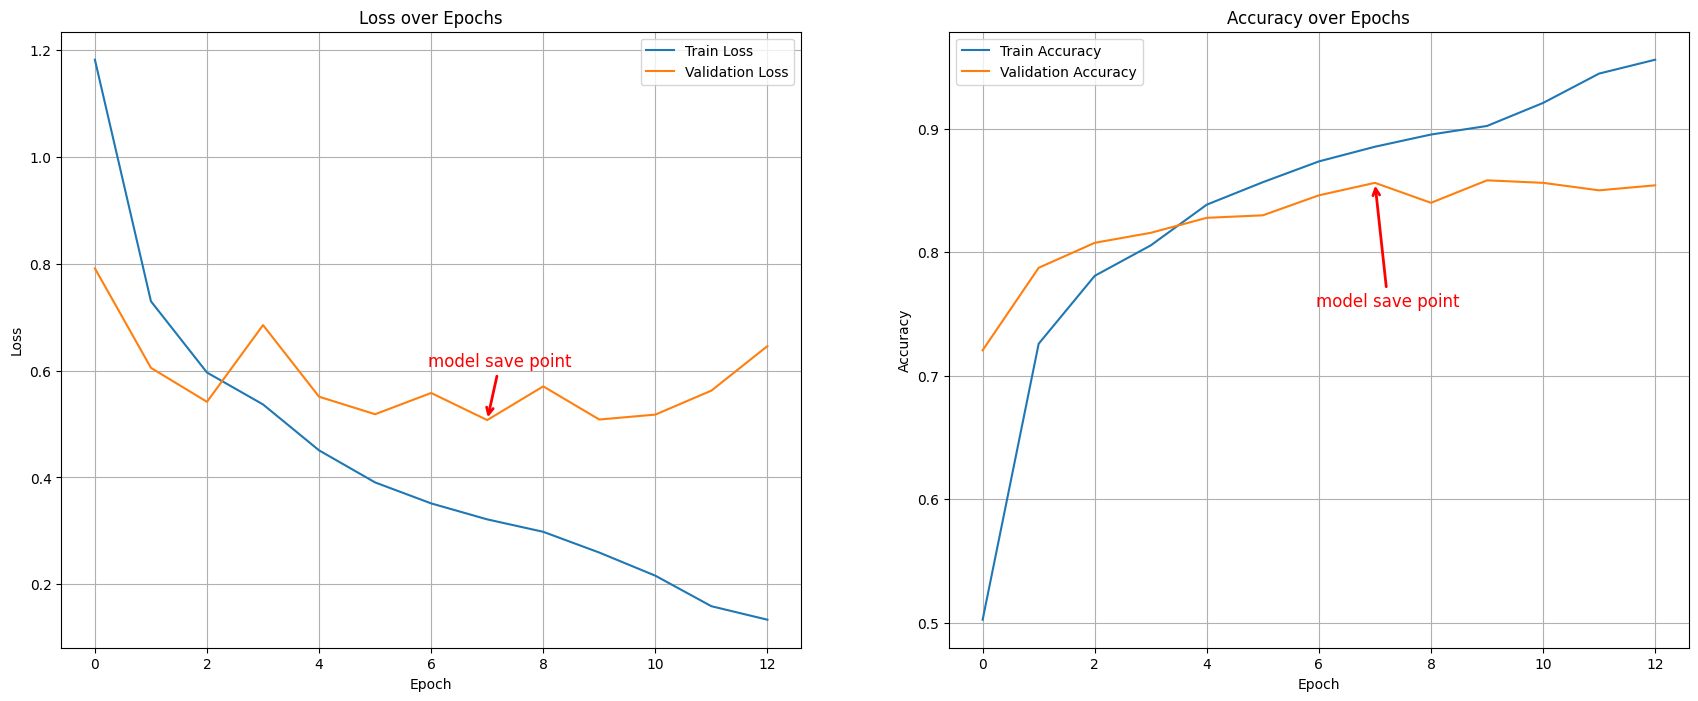

In [27]:
model_save_point = len(val_losses)-PATIENCE-1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 8))

# Plotting Loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.annotate(
    "model save point",
    xy=(model_save_point, val_losses[model_save_point]),
    xytext=(model_save_point-1.05, val_losses[model_save_point]+0.1),
    arrowprops=dict(arrowstyle="->", color="red", lw=2),
    fontsize=12,
    color="red"
    )
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting Accuracy
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.annotate(
    "model save point",
    xy=(model_save_point, val_accs[model_save_point]),
    xytext=(model_save_point-1.05, val_accs[model_save_point]-0.1),
    arrowprops=dict(arrowstyle="->", color="red", lw=2),
    fontsize=12,
    color="red"
    )
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# 10. Inference

In [28]:
idx_to_class = {
    0 : "협박 대화",
    1 : "갈취 대화",
    2 : "직장 내 괴롭힘 대화",
    3 : "기타 괴롭힘 대화",
    4 : "일반 대화"
}

# Inference Example
def predict_class(model, sentence, vocab, idx_to_class, max_seq_len, device):
    model.eval()
    encoded_ids = vocab.encode(sentence)
    input_ids = [vocab.CLS_ID] + encoded_ids
    if len(input_ids) > max_seq_len:
        input_ids = input_ids[:max_seq_len]
    padding_length = max_seq_len - len(input_ids)
    input_ids = input_ids + [vocab.PAD_ID] * padding_length
    tensor = torch.LongTensor(input_ids).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(tensor)
    predicted_index = prediction.argmax(1).item()
    return idx_to_class[predicted_index]

# Load the best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# Test with a sample sentence
sample_sentence = '학교 안갔어? 응.왜? 가기 싫어서. 그래도 가야지. 학생은 학생 다워야지 너 맘대로 안가면 어떻게 해? 알겠어 갈게.'
predicted_label = predict_class(model, sample_sentence, vocab, idx_to_class, MAX_LENGTH, device)
print(f'Sentence: "{sample_sentence}"\n\
        Predicted Class: {predicted_label}')

sample_sentence_2 = '오늘 점심 뭐 먹을지 추천해줄 수 있어? 햄버거나 먹어 돈도 없는 주제에 뭐 먹을 고민해봐야 뭐하니? 흥 너무해. 장난이지. 장난 한번 더 치면 싸우게 생겼네.'
predicted_label_2 = predict_class(model, sample_sentence_2, vocab, idx_to_class, MAX_LENGTH, device)
print(f'Sentence: "{sample_sentence_2}"\n\
        Predicted Class: {predicted_label_2}')

sample_sentence_3 = '오늘도 이런 식으로 나오면 정말 혼나는거야. 알겠어요. 다음부턴 안그러도록 할게요. 그래 다음번에도 이러면 니 가족들 전부 죽는거야.'
predicted_label_3 = predict_class(model, sample_sentence_3, vocab, idx_to_class, MAX_LENGTH, device)
print(f'Sentence: "{sample_sentence_3}"\n\
        Predicted Class: {predicted_label_3}')

Sentence: "학교 안갔어? 응.왜? 가기 싫어서. 그래도 가야지. 학생은 학생 다워야지 너 맘대로 안가면 어떻게 해? 알겠어 갈게."
        Predicted Class: 기타 괴롭힘 대화
Sentence: "오늘 점심 뭐 먹을지 추천해줄 수 있어? 햄버거나 먹어 돈도 없는 주제에 뭐 먹을 고민해봐야 뭐하니? 흥 너무해. 장난이지. 장난 한번 더 치면 싸우게 생겼네."
        Predicted Class: 협박 대화
Sentence: "오늘도 이런 식으로 나오면 정말 혼나는거야. 알겠어요. 다음부턴 안그러도록 할게요. 그래 다음번에도 이러면 니 가족들 전부 죽는거야."
        Predicted Class: 협박 대화


# 11. 제출

In [29]:
# 테스트 데이터 로드 (TEST_PATH는 이미 정의되어 있다고 가정)
test_df = pd.read_csv(TEST_PATH)

class_to_idx = {v: k for k, v in idx_to_class.items()}

# predict_class 함수를 사용하여 각 대화의 레이블 예측
# model, vocab, idx_to_class, MAX_SEQ_LEN, device는 이미 정의되어 있다고 가정
predicted_labels = []
for sentence in test_df['conversation']:
    predicted_label = predict_class(model, sentence, vocab, idx_to_class, MAX_LENGTH, device)
    
    predicted_labels.append(class_to_idx[predicted_label])

# submission.csv 파일 생성 (MODEL_DIR은 이미 정의되어 있다고 가정)
submission_df = pd.DataFrame({
    'idx': test_df['idx'],
    'class': predicted_labels
})
submission_df.to_csv(SUBMIT_PATH, index=False)

print(f"submission.csv 갱신 완료: {SUBMIT_PATH}")

submission.csv 갱신 완료: ./Data/aiffel-dl-thon-dktc-online-15/submission.csv
